# 2 B: Adding more dimensions, without loops

We'll continue on with our heatwave example, this time expanding the analysis to the full 3d dataset

We won't be using any explicit loops, instead we'll rely on Dask to automatically order array operations for us

To start off with we'll load some libraries and the Dask distributed client, so that the analysis is run in parallel.

In [2]:
%matplotlib inline
import numpy
import xarray
import dask.array
from dask.diagnostics import ProgressBar

In [3]:
from dask.distributed import Client, progress
# Client()

## Adding dimensions

For the most part working with multi-dimensional data is exactly the same as 1d data. 'Split' functions take the name of the dimension to work on in either case, so operations like calculating the 15 day rolling average work exactly the same

In [4]:
cmip_tasmax  = '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax*.nc'

ds = xarray.open_mfdataset(cmip_tasmax, chunks={'lat': 50, 'lon': 50, 'time': 1000})
tasmax = ds.tasmax

In [4]:
tasmax_15day = tasmax.rolling(time=15, center=True).mean()

## Sorting - avoid it

There are some types of operations that you really need to avoid when working with large datasets.

Calculating things like min/max, mean and standard deviation are fine, because they can be calculated in a 'rolling' manner - there's no need to load the entire dataset to do the calculation.

Calculating the percentile however requires sorting the data, which is one of the worst things you can do with a large dataset. Sorting requires loading the entire dataset into memory.

In this case we could make the assumption that the temperatures are normally distributed, and use that distribution to get the percentiles. This might not always be valid, so you should validate for yourself assumptions like this work

**Make an estimate of the 90th percentile at each day of the year at each grid point, assuming temperatures are normally distributed**

[`scipy.stats.norm.ppf(q, loc=mean, scale=std)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) could be useful

<a href="#ans1" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans1">
<pre><code>
from scipy.stats import norm

# Show a fancy progress bar
with ProgressBar():
    tasmax_mean = tasmax_15day.groupby('time.dayofyear').mean('time')
    tasmax_std = tasmax_15day.groupby('time.dayofyear').std('time')
    
    # The ppf function isn't dask aware, so it will load the mean and stddev data
    threshold = xarray.DataArray(norm.ppf(0.9, loc=tasmax_mean, scale=tasmax_std), coords=tasmax_mean.coords)
</code></pre>
</div>

**How does our estimate of the 90th percentile compare with the actual value (look at a single grid point)**

<a href="#ans2" data-toggle="collapse">Answer</a>
<div class="collapse" id="ans2">
<pre><code>
with ProgressBar():
    threshold.sel(lat=-37.8136, lon=144.9631, method='nearest').plot()
    tasmax_15day.sel(lat=-37.8136, lon=144.9631, method='nearest').load().groupby('time.dayofyear').reduce(numpy.nanpercentile, q=90, dim='time').plot()
</code></pre>
</div>


In [5]:
p90 = tasmax_15day.groupby('time.dayofyear').reduce(numpy.nanpercentile, q=90, dim='time')

KeyboardInterrupt: 

In [6]:
mean = tasmax_15day.groupby('time.dayofyear').mean('time')
std = tasmax_15day.groupby('time.dayofyear').std('time')

import scipy.stats

with ProgressBar():
    tasmax_p90 = scipy.stats.norm.ppf(0.9, loc = mean, scale=std)

[########################################] | 100% Completed | 23.2s
[########################################] | 100% Completed | 27.8s


In [7]:
tasmax_p90 = xarray.DataArray(tasmax_p90, coords = mean.coords)

[########################################] | 100% Completed |  2.1s


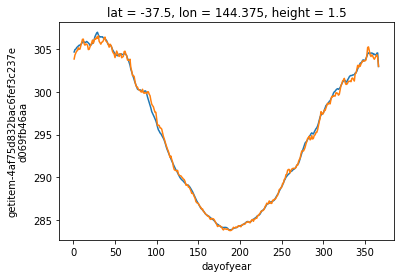

In [8]:
with ProgressBar():
    tasmax_p90.sel(lat=-37.8136, lon=144.9631, method='nearest').plot()
    tasmax_15day.sel(lat=-37.8136, lon=144.9631, method='nearest').load().groupby('time.dayofyear').reduce(numpy.nanpercentile, q=90, dim='time').plot()

In [9]:
candidates = tasmax.where(tasmax.groupby('time.dayofyear') > tasmax_p90)

In [10]:
def heatwave_start_filter(x, axis):
    """
    Returns 1 if a heatwave starts at this time, otherwise nan
    
    Matches the pattern [*, nan, finite, finite, finite] on the rolling dimension
    
    Should be called with x.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter)
    """
    

    # Check assumptions - the rolling axis is the last one, and the window size is 5
    assert axis % x.ndim == x.ndim - 1
    assert x.shape[axis] == 5

    left  = numpy.isnan(x[..., 1]) # Time before this one

    right = numpy.isfinite(x[..., 2:]).all(axis=axis) # This time and two after
    
    test  = numpy.logical_and(left, right)
    filtered =  dask.array.where(test, 1.0, numpy.nan)
    return filtered

In [11]:
with ProgressBar():
    hw_starts = candidates.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter, allow_lazy=True)

## Lazy functions

To get our filter function to work nicely with dask we have to make a couple changes - when we directly run numpy functions, like `numpy.logical_and()`, these need to be replaced with the dask version, `dask.array.logical_and()` in this case.

You'll also need to add an `allow_lazy=True` flag when you call `.reduce()`, to let Xarray know that the filter is a dask-aware function.


### Remember - if we've done things right, operations on dask arrays should return immediately!

In [12]:
def heatwave_start_filter(x, axis):
    """
    Returns 1 if a heatwave starts at this time, otherwise nan
    
    Matches the pattern [*, <0, >=0, >=0, >=0] on the rolling dimension
    
    Should be called with x.rolling(time=5, center=True).reduce(heatwave_start_filter)
    """

    assert axis % x.ndim == x.ndim - 1
    assert x.shape[axis] == 5

    left  = dask.array.isnan(x[..., 1]) # Time before this one

    right = dask.array.isfinite(x[..., 2:]).all(axis=axis) # This time and two after
    
    test  = dask.array.logical_and(left, right)
    return dask.array.where(test, 1.0, numpy.nan)

In [13]:
with ProgressBar():
    hw_starts = candidates.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter, allow_lazy=True)

[########################################] | 100% Completed |  1min 35.6s


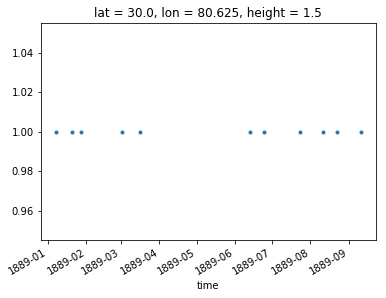

In [16]:
with ProgressBar():
    hw_starts.sel(lat=30, lon=80, method='nearest').sel(time='1889').plot(marker='.')

## Optimisation tips

 * Narrow down your region with `.isel()` before you use a split function
 * After setting up climatologies `.load()` or save to file so they are pre-calculated
 * Use smaller chunk sizes to reduce what dask loads
 
http://xarray.pydata.org/en/stable/dask.html#optimization-tips

For instance, put the analysis into a function, then use a selected region as the input

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

with ProgressBar():
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=140))
    hw_starts.sel(time='1998').count(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
    ax.coastlines()

In [17]:
def find_hw_starts(t):
    candidates = t.where(t.groupby('time.dayofyear') > tasmax_p90)
    return candidates.rolling(time=5, center=True, min_periods=1).reduce(heatwave_start_filter, allow_lazy=True)

[########################################] | 100% Completed | 20.6s
[########################################] | 100% Completed | 20.8s


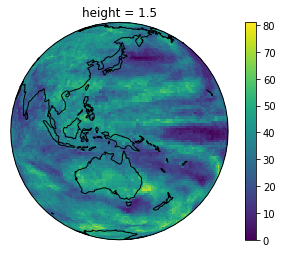

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

with ProgressBar():
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=140))
    find_hw_starts(tasmax.sel(time=slice('1897','1899'))).count(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
    ax.coastlines()

In [26]:
(tasmax.time.dt.year / 2).astype(int)

<xarray.DataArray 'year' (time: 18262)>
array([925, 925, 925, ..., 949, 949, 949])
Coordinates:
    height   float64 1.5
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 1850-01-02T12:00:00 ...

In [27]:
tasmax.coords['twoyear'] = (tasmax.time.dt.year / 2).astype(int)

In [30]:
tasmax.groupby('twoyear').mean('time')

<xarray.DataArray 'tasmax' (twoyear: 25, lat: 145, lon: 192)>
dask.array<shape=(25, 145, 192), dtype=float32, chunksize=(1, 50, 50)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
    height   float64 1.5
  * twoyear  (twoyear) int64 925 926 927 928 929 930 931 932 933 934 935 936 ...